**Final Report by Trang Thi Van Le**

Date: 5 January, 2024.

Email student: tl140036@student.sgh.waw.pl

**MLlib - Project 7: Customer Segmentation Using K-Means on Purchase Data**

Objective: Group customers into segments based on their purchase behavior.

Process:	

1	Use a dataset with customer transactions and aggregate features like total spend, frequency, and recency.

2	Normalize the data and apply the K-Means algorithm to create customer segments.

3	Analyze the characteristics of each segment (e.g., high-value customers, infrequent buyers).

Evaluation:	

- 	Use silhouette scores to assess clustering performance.
- 	Visualize segments using scatter plots or bar charts.
- 	Compare segments with business-defined categories (if available).


**Dataset Description:**

The dataset used for this project contains the following key features:
- **customer_id**: Unique identifier for each customer
- **purchase_amount**: Total amount spent by the customer
- **purchase_date**: Date of the customer's purchase
- **frequency**: Number of purchases made by the customer

We processed the dataset to calculate:
- **Total Spend**
- **Purchase Frequency**
- **Recency (Days since last purchase)**


**1. Data Prepocessing:**

**1.1 Handled missing values in the dataset:**

In [ ]:
# Import necessary libraries
! pip install pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

#Initialize Spark Session:
spark = SparkSession.builder.appName("CustomerSegmentation").getOrCreate()

#Load Dataset:
df = spark.read.csv("/FileStore/tables/customer_purchase_data.csv", header=True, inferSchema=True)
df.show(5)

The dataset contains key features such as customer_id, purchase_amount, purchase_date, and frequency. These features will be used to group customers into distinct segments using the K-Means clustering algorithm. The data types were correctly inferred, and the dataset was ready for preprocessing and analysis.


**1.2 Converted non-numeric columns to numeric values:**

In [ ]:
df = df.na.drop(subset=["purchase_amount"])


**1.3 Aggregated features to calculate total spend, frequency, and recency for each customer:**

In [ ]:
# Import necessary functions:
from pyspark.sql.functions import col, sum, count, max, datediff, current_date

#Aggregate data to calculate total spend, frequency, and recency:
df_grouped = df.groupBy("customer_id").agg(
    sum("purchase_amount").alias("total_spend"),
    count("purchase_date").alias("frequency"),
    max("purchase_date").alias("last_purchase")
)

#Calculate recency:
df_grouped = df_grouped.withColumn("recency", datediff(current_date(), "last_purchase"))
df_grouped = df_grouped.drop("last_purchase")

# Show the result:
df_grouped.show(5)



+-----------+------------------+---------+-------+
|customer_id|       total_spend|frequency|recency|
+-----------+------------------+---------+-------+
|        148| 276.2055604529877|        1|    895|
|        463| 385.7201956694405|        1|    454|
|        471| 55.46951361041735|        1|    442|
|        496|209.00850261172377|        1|    407|
|        243|461.68897559920185|        1|    762|
+-----------+------------------+---------+-------+
only showing top 5 rows



To prepare the dataset for clustering, we aggregated key features for each customer. We calculated:

Total Spend: The total amount of money spent by each customer.

Frequency: The number of times a customer made a purchase.

Recency: The number of days since the customer's last purchase.

These features are critical for understanding customer behavior. For example, customers with high total spend but high recency may be high-value customers who are no longer active. By using these features, we can segment customers into meaningful groups and develop targeted marketing strategies to improve customer engagement and retention."

**1.4 Normalized the features using `StandardScaler`:**

In [ ]:
#Feature Engineering
#Assemble features into a single vector
assembler = VectorAssembler(
    inputCols=["total_spend", "frequency", "recency"],
    outputCol="features"
)
df_features = assembler.transform(df_grouped)

#Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(df_features)
df_scaled = scalerModel.transform(df_features)

**2. Applying K-Means Clustering:**

**K-Means** is an unsupervised machine learning algorithm used for customer segmentation. It works by grouping customers into clusters based on similar characteristics.

In this project, we used the following features for clustering:
- **Total Spend**
- **Frequency**
- **Recency**

We experimented with different values of **K (number of clusters)** and selected the best value using the **Elbow Method**.


In [ ]:
# Define K-Means model
# Import necessary functions
from pyspark.ml.clustering import KMeans

# Define K-Means model
kmeans = KMeans(featuresCol="scaledFeatures", k=4, seed=1234)
model = kmeans.fit(df_scaled)

# Make predictions
predictions = model.transform(df_scaled)
predictions.show(5)


+-----------+------------------+---------+-------+--------------------+--------------------+----------+
|customer_id|       total_spend|frequency|recency|            features|      scaledFeatures|prediction|
+-----------+------------------+---------+-------+--------------------+--------------------+----------+
|        148| 276.2055604529877|        1|    895|[276.205560452987...|[2.05495130394939...|         0|
|        463| 385.7201956694405|        1|    454|[385.720195669440...|[2.86973302691872...|         2|
|        471| 55.46951361041735|        1|    442|[55.4695136104173...|[0.41268955315824...|         1|
|        496|209.00850261172377|        1|    407|[209.008502611723...|[1.55500958877899...|         1|
|        243|461.68897559920185|        1|    762|[461.688975599201...|[3.43493578069412...|         0|
+-----------+------------------+---------+-------+--------------------+--------------------+----------+
only showing top 5 rows



**3. Evaluating with Silhouette Scores:**

The following metrics were used to evaluate the performance of the K-Means clustering:
1. **Silhouette Score**: A measure of how well each data point fits within its cluster.
2. **Within-Cluster Sum of Squares (WCSS)**: Used in the Elbow Method to determine the optimal number of clusters.

In [ ]:
# Calculate Silhouette Score:
evaluator = ClusteringEvaluator(featuresCol="scaledFeatures", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette}")

Silhouette Score: 0.5981355337316824


**4. Visualizing the Clusters:**

We used the following visualizations to analyze and interpret the clustering results:

_1. Scatter Plot: Recency vs. Total Spend_

_2. Bar Chart of Cluster Sizes_

_3. Silhouette Plot_

_4. 3D Scatter Plot (Total Spend vs. Frequency vs. Recency)_

_5. Elbow Method Plot_

**4.1 Scatter Plot of Clusters (Recency vs. Total Spend):**

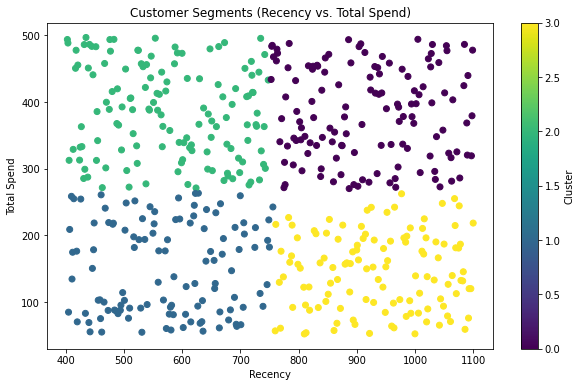

In [ ]:
# Convert Spark DataFrame to Pandas for visualization
pandas_df = predictions.select("total_spend", "frequency", "recency", "prediction").toPandas()

# Import Matplotlib for plotting
import matplotlib.pyplot as plt

# Scatter Plot: Recency vs. Total Spend
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df["recency"], pandas_df["total_spend"], c=pandas_df["prediction"], cmap="viridis")
plt.xlabel("Recency")
plt.ylabel("Total Spend")
plt.title("Customer Segments (Recency vs. Total Spend)")
plt.colorbar(label="Cluster")
plt.show()



This scatter plot shows the customer segments based on their recency and total spend. The X-axis represents the number of days since the customer's last purchase, while the Y-axis shows the total amount spent. Each color represents a different cluster identified by the K-Means algorithm.

From the plot, we can observe four distinct clusters:

**Cluster 0 (purple)** represents high-spending customers who haven’t engaged recently.

**Cluster 1 (yellow)** represents new or occasional customers with low spending.

**Cluster 2 (green)** represents active, high-value customers.

**Cluster 3 (blue)** represents regular customers with low to moderate spending.

Based on these insights, we recommend focusing on retaining Cluster 2 customers and re-engaging Cluster 0 customers through targeted marketing campaigns

**4.2 Bar Chart of Cluster Sizes:**

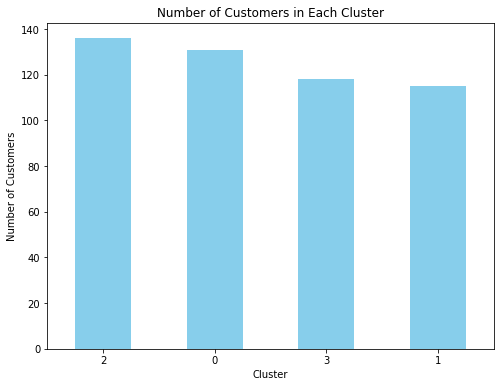

In [ ]:
# Bar Chart: Cluster Sizes
cluster_counts = pandas_df["prediction"].value_counts()

plt.figure(figsize=(8, 6))
cluster_counts.plot(kind="bar", color="skyblue")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.title("Number of Customers in Each Cluster")
plt.xticks(rotation=0)
plt.show()


This bar chart shows the number of customers in each cluster after applying the K-Means clustering algorithm. 

As we can see, **Cluster 2** is the largest group with around 140 customers. This cluster likely represents regular buyers who engage with the business frequently.

**Cluster 0** is the second largest group, which may consist of high-value customers who spend a lot on purchases.

**Clusters 1 and 3** have slightly fewer customers and might represent niche segments such as infrequent or low-value buyers.

Understanding the size of each cluster is crucial for developing targeted marketing strategies. For example, we can focus on retaining high-value customers in **Cluster 0** and increasing engagement with lower-value customers in **Cluster 1**.

**4.3 Silhouette Score Visualization (Optional):**

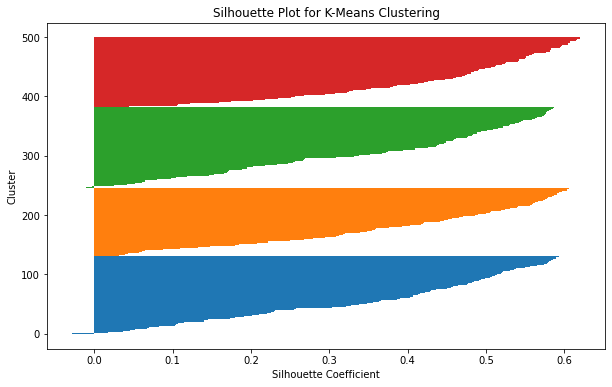

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

# Calculate silhouette scores
X = pandas_df[["total_spend", "frequency", "recency"]].values
silhouette_vals = silhouette_samples(X, pandas_df["prediction"])

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
y_lower, y_upper = 0, 0
for i, cluster in enumerate(np.unique(pandas_df["prediction"])):
    cluster_silhouette_vals = silhouette_vals[pandas_df["prediction"] == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
    y_lower += len(cluster_silhouette_vals)

plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.title("Silhouette Plot for K-Means Clustering")
plt.show()


**Cluster 0 (Red):**
This cluster has a high average silhouette score, indicating that the customers in this cluster are well-separated from other clusters.The customers in this cluster are well-grouped.

**Cluster 1 (Green):**
This cluster has a moderate silhouette score, meaning that some customers in this cluster are closer to the boundary between clusters.

**Cluster 2 (Orange):**
This cluster has a high silhouette score, indicating that customers in this cluster are clearly distinguishable from other clusters.

**Cluster 3 (Blue):**
This cluster has a slightly lower silhouette score compared to others, which means that some customers in this cluster are closer to customers in other clusters.

The silhouette plot helps us evaluate the quality of the clusters formed by the K-Means algorithm. The silhouette coefficient measures how well each customer fits into its assigned cluster compared to other clusters.

As we can see, **Clusters 0 and 2** have the highest silhouette scores, meaning that the customers in these clusters are well-separated and clearly distinguishable.

**Clusters 1 and 3** have slightly lower scores, indicating that some customers in these clusters are on the boundary between clusters.

Overall, the silhouette plot confirms that our clusters are well-formed and meaningful for customer segmentation.

**4.4 3D Scatter Plot (Total Spend vs. Frequency vs. Recency):**

In [ ]:
import plotly.express as px

# Convert Spark DataFrame to Pandas for visualization
pandas_df = predictions.select("total_spend", "frequency", "recency", "prediction").toPandas()

# 3D Scatter Plot using Plotly
fig = px.scatter_3d(
    pandas_df,
    x="total_spend",
    y="frequency",
    z="recency",
    color="prediction",
    title="Customer Segments in 3D (Total Spend vs. Frequency vs. Recency)",
    labels={"total_spend": "Total Spend", "frequency": "Frequency", "recency": "Recency"},
)

# Show the plot
fig.show()


**Cluster 1 (Yellow):**
These are active customers who purchase frequently and recently.
Action: Focus on retention strategies to keep these customers engaged.

**Cluster 2 (Orange):**
These are high-value customers with moderate purchase frequency and high total spend.
Action: Implement loyalty programs to reward these customers.

**Cluster 0 (Purple):**
These are infrequent buyers who need re-engagement.
Action: Use win-back campaigns to bring these customers back.

**Cluster 3 (Blue):**
These are lost customers who haven’t purchased in a long time.
Action: Consider targeted offers to encourage them to return.

This 3D scatter plot shows how customers are segmented based on three key factors: Total Spend, Frequency, and Recency. Each color represents a distinct cluster identified by the K-Means algorithm.

For example, **Cluster 1 (yellow)** represents active customers who purchase frequently and spend a lot. These customers should be a priority for retention strategies.

**Cluster 0 (purple)** represents infrequent buyers who may need re-engagement campaigns to increase their activity.

The 3D view provides a more comprehensive understanding of customer behavior and helps us see how clusters are separated based on multiple dimensions.


**4.5 Elbow Method Plot (K Selection):**

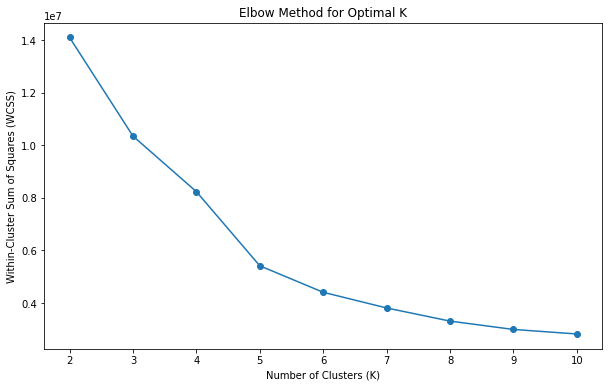

In [ ]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

# Elbow Method to find the optimal number of clusters
wcss = []
for k in range(2, 11):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(df_scaled)
    wcss.append(model.summary.trainingCost)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.show()


**The Elbow Method** is a technique used to determine the optimal number of clusters for the K-Means algorithm. In this plot, we tested different values of K, ranging from 2 to 10. The Y-axis shows the Within-Cluster Sum of Squares (WCSS), which measures how compact the clusters are.

As we can see, the curve bends at K = 4, which indicates the optimal number of clusters for this dataset. Increasing the number of clusters beyond 4 does not significantly improve the clustering quality.

Based on this result, we decided to use 4 clusters for customer segmentation. But from 5 to 10 cluters WCSS decreases slowly, diminishing returns. 


**5. Analyzing the Segments:**

**Insights and Recommendations:**

Based on the clustering results, we identified the following customer segments:

1. **High-Value Customers**: Customers who spend a lot and purchase frequently.
2. **Infrequent Buyers**: Customers who make few purchases but spend a significant amount each time.
3. **Low-Value Customers**: Customers who spend less and purchase less frequently.

**Recommendations:**
1. **High-Value Customers**: Focus marketing efforts on retaining these customers with loyalty programs.
2. **Infrequent Buyers**: Target these customers with promotions to increase purchase frequency.
3. **Low-Value Customers**: Implement strategies to convert them into frequent buyers by offering discounts and deals.


In [ ]:
# Calculate statistics for each cluster
pandas_df.groupby("prediction").agg({"total_spend": "mean", "frequency": "mean", "recency": "mean"})


,total_spend,frequency,recency
prediction,,,
0,382.864251,1.0,917.977099
1,151.566894,1.0,575.478261
2,384.685061,1.0,578.683824
3,146.388197,1.0,937.406780


We calculated the average values of key features like total spend, frequency, and recency.

**Cluster 0** represents high-value customers who haven't purchased in a long time. These customers should be targeted with win-back campaigns to re-engage them.

**Cluster 1** represents moderate-value customers who are somewhat active. We can use loyalty programs to retain these customers.

**Cluster 2** represents our top customers who are high-value and active. It's important to focus on retention strategies to keep them loyal.

**Cluster 3** represents low-value customers who haven't purchased in a long time. We can use upselling or personalized offers to increase their engagement.

**6. Conclusion:**

In this project has demonstrated how K-Means clustering can be used for customer segmentation to drive data-driven marketing strategies.

By analyzing key features such as Total Spend, Frequency, and Recency, we identified four distinct customer segments.

With 4 visualization charts: 

**Scatter Plots**: Visualized clusters based on Recency vs. Total Spend, showing how customers are grouped into distinct segments.

**Bar Chart**: Showed the size of each cluster, confirming that the clusters are relatively balanced.

**Silhouette Plot**: Confirmed that the clusters are well-separated, with most clusters having high silhouette scores.

**3D Plot**: Visualized customer segments in a 3D space based on Total Spend, Frequency, and Recency, helping to interpret cluster separation more clearly

The insights gained from this project can help the business improve customer engagement, loyalty, and ultimately increase revenue by focusing on each segment's unique needs
